## **Identifying Key Contributors to Road Traffic Accidents Using XGBoost and Exploratory Data Analysis**
### Objectives
* To explore and analyze road traffic crash data to understand patterns and trends in accidents.
* To develop a predictive machine learning model to classify accident severity.
* To evaluate the performance of the predictive model using appropriate metrics such as accuracy, precision, recall and F1-score.
* To provide data-driven recommendations for improving road safety and reducing accident severity.

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-darkgrid')
sns.set_style('darkgrid', {'axes.facecolor':'0.9'})
from scipy.stats import f_oneway
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score

Loading the datasets

In [2]:
crashes=pd.read_csv('./data/Traffic_Crashes_-_Crashes.csv.gz', low_memory=False)
people=pd.read_csv('./data/Traffic_Crashes_-_People.csv.gz', low_memory=False)
vehicles=pd.read_csv('./data/Traffic_Crashes_-_Vehicles.csv.gz', low_memory=False)

### Exploring the crashes dataset

In [3]:
# checking the info of the crashes dataset
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH_RECORD_ID                54959 non-null  object 
 1   CRASH_DATE_EST_I               3503 non-null   object 
 2   CRASH_DATE                     54959 non-null  object 
 3   POSTED_SPEED_LIMIT             54959 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         54959 non-null  object 
 5   DEVICE_CONDITION               54959 non-null  object 
 6   WEATHER_CONDITION              54959 non-null  object 
 7   LIGHTING_CONDITION             54959 non-null  object 
 8   FIRST_CRASH_TYPE               54959 non-null  object 
 9   TRAFFICWAY_TYPE                54959 non-null  object 
 10  LANE_CNT                       6 non-null      float64
 11  ALIGNMENT                      54959 non-null  object 
 12  ROADWAY_SURFACE_COND           54959 non-null 

In [4]:
# Checking the column names of the crashes dataset
crashes.columns

Index(['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 

In [5]:
# Checking for duplicate records in the crashes dataset
crashes.CRASH_RECORD_ID.duplicated().sum()

0

In [6]:
# Checking the values	counts of the MOST_SEVERE_INJURY column
crashes.MOST_SEVERE_INJURY.value_counts()

NO INDICATION OF INJURY     45514
NONINCAPACITATING INJURY     4982
REPORTED, NOT EVIDENT        3502
INCAPACITATING INJURY         809
FATAL                          47
Name: MOST_SEVERE_INJURY, dtype: int64

#### Creating a binary target variable using the IS_SEVERE column.

In [7]:
# Defining the severity of the accidents based on injury levels
crashes['IS_SEVERE'] = (
    (crashes['INJURIES_INCAPACITATING'] > 0) |
    (crashes['INJURIES_FATAL'] > 0)
)

In [8]:
# Checking the values counts of the ROADWAY_SURFACE_COND column
crashes.ROADWAY_SURFACE_COND.value_counts()

DRY                40314
UNKNOWN             7662
WET                 4588
SNOW OR SLUSH       1937
ICE                  271
OTHER                175
SAND, MUD, DIRT       12
Name: ROADWAY_SURFACE_COND, dtype: int64

###	Combining rare categories in the ROADWAY_SURFACE_COND column

In [9]:
crashes['ROADWAY_SURFACE_COND'].replace(['SAND, MUD, DIRT', 'OTHER'], 'OTHER_RARE', inplace=True)

In [10]:
# Checking the values counts of the WEATHER_CONDITION column
crashes.WEATHER_CONDITION.value_counts()

CLEAR                       44097
UNKNOWN                      4525
RAIN                         2825
SNOW                         1751
CLOUDY/OVERCAST              1379
OTHER                         200
FREEZING RAIN/DRIZZLE          74
BLOWING SNOW                   42
SLEET/HAIL                     40
FOG/SMOKE/HAZE                 22
SEVERE CROSS WIND GATE          3
BLOWING SAND, SOIL, DIRT        1
Name: WEATHER_CONDITION, dtype: int64

### Combining rare categories in the WEATHER_CONDITION column

In [11]:
crashes['WEATHER_CONDITION'].replace(['BLOWING SAND, SOIL, DIRT', 'OTHER'], 'OTHER_RARE', inplace=True)

### Analyzing the relationship between ROADWAY_SURFACE_COND and accident severity

In [12]:
crashes.groupby('ROADWAY_SURFACE_COND')['IS_SEVERE'].mean().sort_values(ascending=False)

ROADWAY_SURFACE_COND
WET              0.022886
DRY              0.016892
SNOW OR SLUSH    0.011874
OTHER_RARE       0.010695
ICE              0.007380
UNKNOWN          0.005612
Name: IS_SEVERE, dtype: float64

#### **In wet roadway surface the rate of injury severity is highest.**

### **Data Transformation: Discretization of Speed Limits.**
### Categorizing speed limits into ranges for comparative analysis.

In [13]:
#Converting the continuous POSTED_SPEED_LIMIT column into a discrete categorical feature named `SPEED_BIN`.
crashes['SPEED_BIN'] = pd.cut(
	crashes['POSTED_SPEED_LIMIT'],
	bins=[0, 25, 35, 45, 55, 65, 100],
	labels=['≤25', '30-35', '40-45', '50-55', '60-65', '65+'],
	include_lowest=True)

### **Distribution of Severe Injury Rates by Speed Limit**

#### The likelihood of a severe injury occurring in different speed limit zones

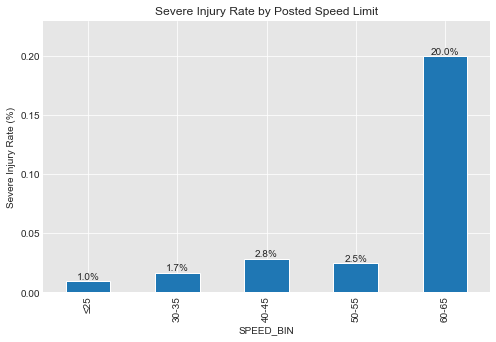

In [14]:
rates = crashes.groupby('SPEED_BIN')['IS_SEVERE'].mean()
rates = rates.dropna()
ax = rates.plot(kind='bar', figsize=(8,5))
plt.ylabel('Severe Injury Rate (%)')
plt.title('Severe Injury Rate by Posted Speed Limit')
plt.ylim(0, rates.max() * 1.15)
for i, rate in enumerate(rates):
    ax.text(
        i,
        rate,
        f"{rate:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

#### **The percentages represent the probability of a severe injury given a specific posted speed limit category. The likelihood of severe injuries in speed limits ranging from 60-65km/h is 20%.**

### **What are the Top 10 Streets with the highest number of crashes?**


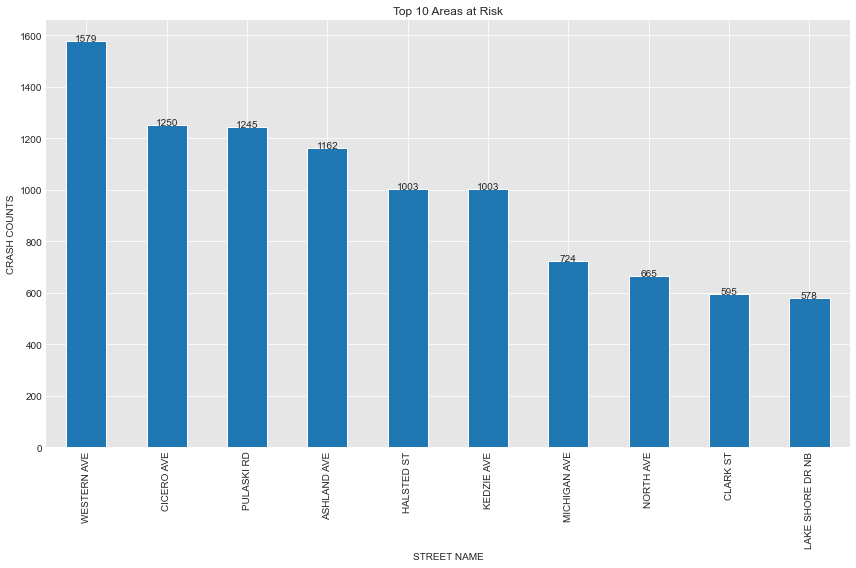

In [15]:
# top 10 areas at risk
top_10_risk_areas = crashes.STREET_NAME.value_counts().head(10)
top_10_risk_areas.plot(kind='bar', figsize=(12,8))
plt.title('Top 10 Areas at Risk')
plt.ylabel('CRASH COUNTS')
plt.xlabel('STREET NAME')
for i, rate in enumerate(top_10_risk_areas):
    plt.text(i, rate, s=f'{rate}', ha='center', fontsize=10)
plt.tight_layout();

#### **Western Avenue has the highest number of crashes with 1579 incidents followed by Cicero Avenue and Pulaski Road with more that 1200 crashes each.**

### **What is Crash Type Distribution?**

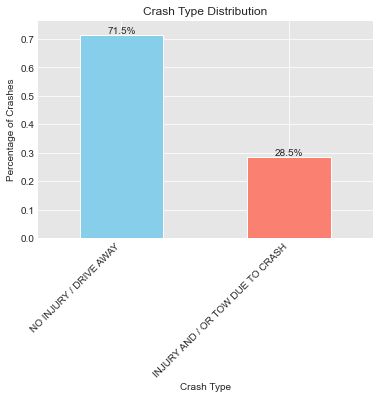

In [16]:
crash_type = crashes['CRASH_TYPE'].value_counts(normalize=True)
# Bar plot
crash_type.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Crash Type Distribution')
plt.xlabel('Crash Type')
plt.ylabel('Percentage of Crashes')
plt.ylim(0, crash_type.max() + 0.05)
plt.xticks(rotation=45, ha='right')
for i, rate in enumerate(crash_type):
    plt.text(
        i,
        rate + 0.005,
        f"{rate:.1%}",
        ha='center',
        fontsize=10
    );

#### **71.5%	of crashes result in No Injury / Property Damage Only, while 28.5% involve Injury and/or Fatal outcomes.**

## Analyzing primary contributing causes

In [17]:
# Checking the top 10 primary contributory causes of crashes
crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().head(10)

UNABLE TO DETERMINE                       22702
FAILING TO YIELD RIGHT-OF-WAY              6533
FOLLOWING TOO CLOSELY                      4989
IMPROPER OVERTAKING/PASSING                3034
NOT APPLICABLE                             2457
FAILING TO REDUCE SPEED TO AVOID CRASH     2269
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE        2189
IMPROPER TURNING/NO SIGNAL                 1899
IMPROPER LANE USAGE                        1833
IMPROPER BACKING                           1703
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: int64

### **What are the top 10 primary contributory causes of crashes?**

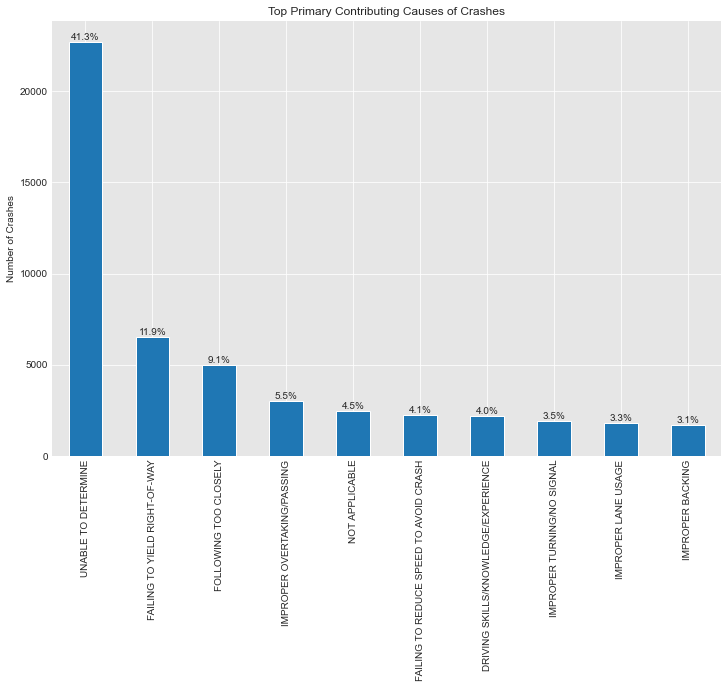

In [18]:
# Plot of top primary contributing causes of crashes
crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().head(10).plot(kind='bar', figsize=(12,8))
plt.title("Top Primary Contributing Causes of Crashes")
plt.ylabel("Number of Crashes")
plt.xticks(rotation=90)
total = crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().sum()
for i, rate in enumerate(crashes.PRIM_CONTRIBUTORY_CAUSE.value_counts().head(10)):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

#### **The leading	primary contributory cause of crashes is 'Unable to determine' but 'Failure to Yield Right-of-Way', 'Following Too Closely' and 'Improper Lane Usage' were among the top causes of the crashes that were determined.**

## Time-Based Analysis

### **What time of day do most crashes occur?**

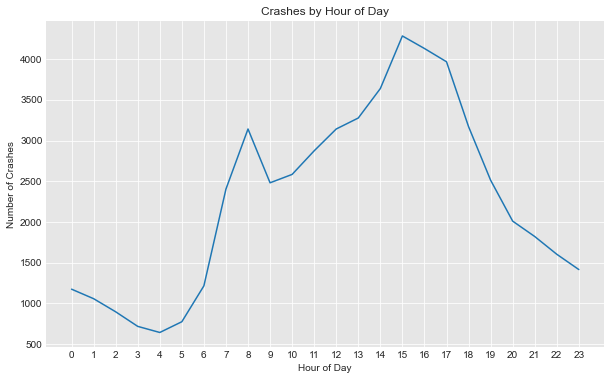

In [19]:
# Crash By Hour Plot
plt.figure(figsize=(10,6))
crashes['CRASH_HOUR'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Hour of Day')
plt.xticks(range(0,24))
plt.ylabel('Number of Crashes')
plt.title("Crashes by Hour of Day");

#### **Most crashes	occur during the afternoon hours, peaking around 3 PM to 6 PM, likely due to increased traffic during rush hour.**

### **What was the cause of crashes at 3 PM?**

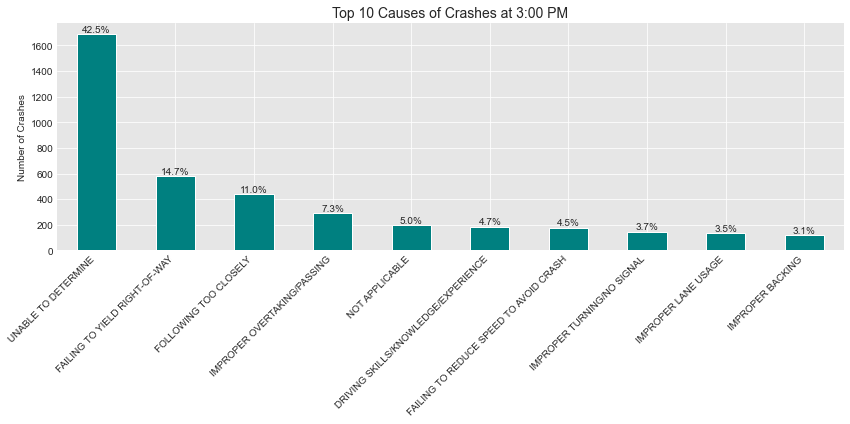

In [20]:
accidents_at_3pm = crashes[crashes["CRASH_HOUR"] == 15]
cause_col = [c for c in crashes.columns if 'CONTRIBUTORY_CAUSE' in c][0]
cause_counts = accidents_at_3pm[cause_col].value_counts().head(10)
plt.figure(figsize=(12, 6))
cause_counts.plot(kind='bar', color='teal')
plt.title(f'Top 10 Causes of Crashes at 3:00 PM', fontsize=14)
plt.ylabel('Number of Crashes')
plt.xticks(rotation=45, ha='right')
total_at_hour = cause_counts.sum()
for i, count in enumerate(cause_counts):
    plt.text(i, count + 0.1, f'{(count/total_at_hour):.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### **The top causes	of crashes at 3 PM include 'Failure to Yield Right-of-Way', 'Following Too Closely', and 'Disregard Traffic Control Device'. These causes highlight common driver errors during peak traffic hours.**

### **What day of the week do most crashes occur?**

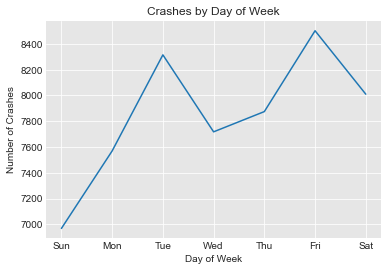

In [21]:
# Crashes By Day of Week Plot
crashes['CRASH_DAY_OF_WEEK'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Day of Week')
plt.xticks(range(1,8), ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.ylabel('Number of Crashes')
plt.title("Crashes by Day of Week");

#### **Friday and Tuesday have highest number of crashes with more than 8200 crashes while Sunday record the least number of crashes.**

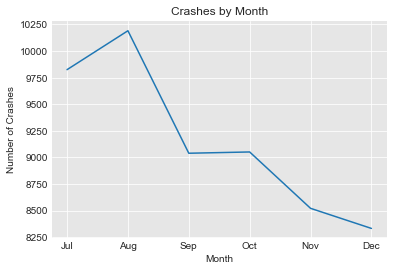

In [22]:
# Crash distribution monthly
crashes['CRASH_MONTH'].value_counts().sort_index().plot(kind='line')
plt.xlabel('Month')
plt.xticks(range(7,13), ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Number of Crashes')
plt.title("Crashes by Month");

#### **August and July (Summer) have	the highest number of crashes while December(Winter) has the least number of crashes.**

## Statistical Tests

H<sub>0</sub>: Weather condition does not affect injuries VS
H<sub>1</sub>: Weather affects injuries at 1% level of significance

In [23]:
groups = [
    crashes[crashes['WEATHER_CONDITION'] == w]['INJURIES_TOTAL'].dropna()
    for w in crashes['WEATHER_CONDITION'].unique()
]
f_oneway(*groups)

F_onewayResult(statistic=36.390952708299125, pvalue=7.888266197739882e-72)

## Weather significantly affects the number of injuries.

H<sub>0</sub>: Lighting condition does not affect injuries VS
H<sub>1</sub>: Lighting affects injuries at 1% level of significance

In [24]:
groups = [
    crashes[crashes['LIGHTING_CONDITION'] == w]['INJURIES_TOTAL'].dropna()
    for w in crashes['LIGHTING_CONDITION'].unique()
]
f_oneway(*groups)

F_onewayResult(statistic=88.11142785500279, pvalue=1.2734770215895415e-92)

## Lighting condition affects the number of injuries at 1% level of significance.

In [25]:
crashes=crashes[['CRASH_RECORD_ID','WEATHER_CONDITION','LIGHTING_CONDITION','CRASH_TYPE','CRASH_HOUR','CRASH_MONTH','NUM_UNITS', 'ROADWAY_SURFACE_COND', 'POSTED_SPEED_LIMIT', 'IS_SEVERE', 'PRIM_CONTRIBUTORY_CAUSE', 'SPEED_BIN', 'CRASH_DAY_OF_WEEK', 'TRAFFIC_CONTROL_DEVICE', 'FIRST_CRASH_TYPE']]

In [26]:
vehicles.columns

Index(['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO',
       'UNIT_TYPE', 'NUM_PASSENGERS', 'VEHICLE_ID', 'CMRC_VEH_I', 'MAKE',
       'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT',
       'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER',
       'TOWED_I', 'FIRE_I', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY',
       'TOWED_TO', 'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I',
       'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I',
       'AREA_09_I', 'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I',
       'FIRST_CONTACT_POINT', 'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO',
       'COMMERCIAL_SRC', 'GVWR', 'CARRIER_NAME', 'CARRIER_STATE',
       'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO',
       'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO',
       'MCS_REPORT_I', 'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I',
       'MCS_VIO_CAUSE_CRASH_I', 'IDOT_PERMIT_NO', 'WIDE_LOAD_I',
       'TRAILER1_

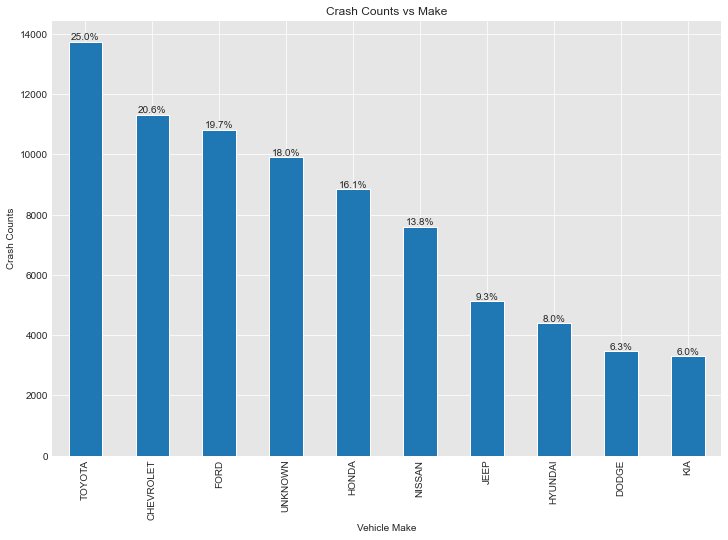

In [27]:
# Plot of Vehicle Make against their number of appearances in crashes.
vehicles.MAKE.value_counts().head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Vehicle Make')
plt.ylabel('Crash Counts')
plt.title('Crash Counts vs Make')
for i, rate in enumerate(vehicles.MAKE.value_counts().head(10)):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

In [28]:
people.columns

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID',
       'CRASH_DATE', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL',
       'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY',
       'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE',
       'CELL_PHONE_USE'],
      dtype='object')

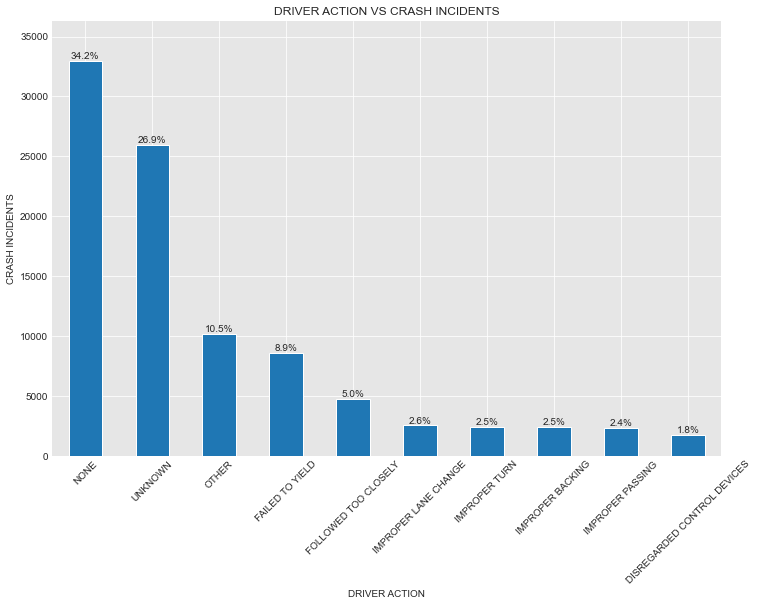

In [29]:
# Plot of Driver Action Count.
people.DRIVER_ACTION.value_counts().head(10).plot(kind='bar', figsize=(12,8))
plt.title('DRIVER ACTION VS CRASH INCIDENTS')
plt.xlabel('DRIVER ACTION')
plt.ylabel('CRASH INCIDENTS')
plt.xticks(rotation=45)
plt.ylim(0, people.DRIVER_ACTION.value_counts().max() * 1.1)
total = people.DRIVER_ACTION.value_counts().sum()
for i, rate in enumerate(people.DRIVER_ACTION.value_counts().head(10)):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

In [30]:
vehicle_agg = vehicles.groupby('CRASH_RECORD_ID').agg({
    'OCCUPANT_CNT': 'sum'
}).reset_index()

In [31]:
vehicle_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CRASH_RECORD_ID  54959 non-null  object 
 1   OCCUPANT_CNT     54959 non-null  float64
dtypes: float64(1), object(1)
memory usage: 858.9+ KB


In [32]:
people_agg = people.groupby('CRASH_RECORD_ID').agg({
    'AGE': 'mean',
    'SAFETY_EQUIPMENT': lambda x: ((x == 'SAFETY BELT USED') | 
                                   (x == 'BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)') |
                                   (x == 'CHILD RESTRAINT - REAR FACING') |
                                   (x == 'CHILD RESTRAINT - FORWARD FACING') |
                                   (x == 'BOOSTER SEAT')).sum()
}).reset_index()

In [33]:
people_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54854 entries, 0 to 54853
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CRASH_RECORD_ID   54854 non-null  object 
 1   AGE               45740 non-null  float64
 2   SAFETY_EQUIPMENT  54854 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ MB


In [34]:
people_agg.AGE.fillna(people_agg.AGE.mean(), inplace=True)

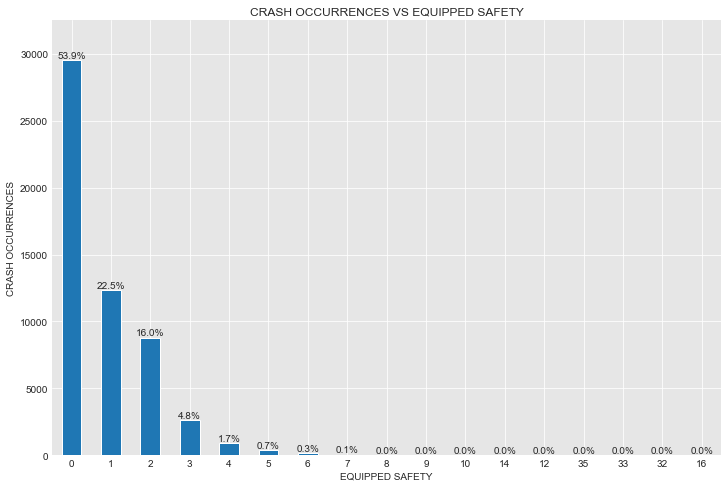

In [35]:
# Crash occurence vs safety equipment plot
equipment_rates=people_agg.SAFETY_EQUIPMENT.value_counts()
equipment_rates.plot(kind='bar', figsize=(12,8))
plt.title('CRASH OCCURRENCES VS EQUIPPED SAFETY')
plt.xlabel('EQUIPPED SAFETY')
plt.ylabel('CRASH OCCURRENCES')
plt.xticks(rotation=0)
plt.ylim(0, equipment_rates.max() * 1.1)
total = equipment_rates.sum()
for i, rate in enumerate(equipment_rates):
    plt.text(
        i,
        rate,
        f"{rate/total:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    );

In [36]:
# Merging DataFrames.
vehicle_people_df=pd.merge(people_agg, vehicle_agg, on='CRASH_RECORD_ID', how='inner')
final_df=pd.merge(crashes, vehicle_people_df, on='CRASH_RECORD_ID', how='inner')

In [37]:
crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54959 entries, 0 to 54958
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   CRASH_RECORD_ID          54959 non-null  object  
 1   WEATHER_CONDITION        54959 non-null  object  
 2   LIGHTING_CONDITION       54959 non-null  object  
 3   CRASH_TYPE               54959 non-null  object  
 4   CRASH_HOUR               54959 non-null  int64   
 5   CRASH_MONTH              54959 non-null  int64   
 6   NUM_UNITS                54959 non-null  int64   
 7   ROADWAY_SURFACE_COND     54959 non-null  object  
 8   POSTED_SPEED_LIMIT       54959 non-null  int64   
 9   IS_SEVERE                54959 non-null  bool    
 10  PRIM_CONTRIBUTORY_CAUSE  54959 non-null  object  
 11  SPEED_BIN                54959 non-null  category
 12  CRASH_DAY_OF_WEEK        54959 non-null  int64   
 13  TRAFFIC_CONTROL_DEVICE   54959 non-null  object  
 14  FIRST_

In [38]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54854 entries, 0 to 54853
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   CRASH_RECORD_ID          54854 non-null  object  
 1   WEATHER_CONDITION        54854 non-null  object  
 2   LIGHTING_CONDITION       54854 non-null  object  
 3   CRASH_TYPE               54854 non-null  object  
 4   CRASH_HOUR               54854 non-null  int64   
 5   CRASH_MONTH              54854 non-null  int64   
 6   NUM_UNITS                54854 non-null  int64   
 7   ROADWAY_SURFACE_COND     54854 non-null  object  
 8   POSTED_SPEED_LIMIT       54854 non-null  int64   
 9   IS_SEVERE                54854 non-null  bool    
 10  PRIM_CONTRIBUTORY_CAUSE  54854 non-null  object  
 11  SPEED_BIN                54854 non-null  category
 12  CRASH_DAY_OF_WEEK        54854 non-null  int64   
 13  TRAFFIC_CONTROL_DEVICE   54854 non-null  object  
 14  FIRST_

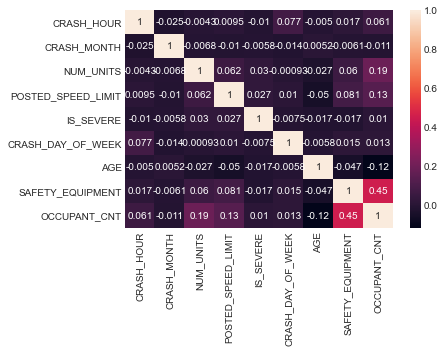

In [39]:
sns.heatmap(final_df.corr(), annot=True);

### There are no highly correlated features

## MODELLING

In [40]:
# Selecting features based on EDA
features = crashes[['WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'FIRST_CRASH_TYPE', 'TRAFFIC_CONTROL_DEVICE', 'POSTED_SPEED_LIMIT']]
target = crashes['PRIM_CONTRIBUTORY_CAUSE']

In [41]:

target.value_counts().sort_values()

MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT                                               1
BICYCLE ADVANCING LEGALLY ON RED LIGHT                                                  2
DISREGARDING YIELD SIGN                                                                 4
OBSTRUCTED CROSSWALKS                                                                  10
PASSING STOPPED SCHOOL BUS                                                             10
TEXTING                                                                                11
HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)                                        31
DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)            34
RELATED TO BUS STOP                                                                    38
TURNING RIGHT ON RED                                                                   45
ANIMAL                                                                                 52
CELL PHONE

In [42]:

target_clean = target.where(
    target.map(target.value_counts()) >= 500,
    other='OTHER'
)

In [43]:
grouping_map = {
'UNABLE TO DETERMINE': 'UNKNOWN',
'NOT APPLICABLE': 'UNKNOWN',
'FAILING TO YIELD RIGHT-OF-WAY': 'VIOLATION',
'DISREGARDING TRAFFIC SIGNALS': 'VIOLATION',
'FOLLOWING TOO CLOSELY': 'DRIVER_ERROR',
'IMPROPER BACKING': 'DRIVER_ERROR',
'IMPROPER LANE USAGE': 'DRIVER_ERROR',
'IMPROPER TURNING/NO SIGNAL': 'DRIVER_ERROR',
'IMPROPER OVERTAKING/PASSING': 'DRIVER_ERROR',
'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE': 'DRIVER_ERROR',
'WEATHER': 'ENVIRONMENT',
'FAILING TO REDUCE SPEED TO AVOID CRASH': 'SPEED_RELATED'
}
y_grouped = target_clean.map(grouping_map).fillna('OTHER')

In [44]:
# Grouping (everything else becomes 'OTHER')
y_final = crashes['PRIM_CONTRIBUTORY_CAUSE'].map(grouping_map).fillna('OTHER')

In [45]:
X_train, X_test, y_train, y_test = train_test_split(features, y_final, test_size=0.3, random_state=42, stratify=y_final)

#### Encoding the target variable 

In [46]:
# Instantiate the encoder
encoder = LabelEncoder()

# Fit and transform the training data
train_encoded=encoder.fit_transform(y_train)

# Transform the test data
test_encoded=encoder.transform(y_test)

# inspect the values of y_train and y_test
print(set(list(train_encoded)))
print(set(list(test_encoded)))

{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5}


In [47]:
categorical_cols = X_train.select_dtypes(include='object').columns
numeric_cols = X_train.select_dtypes(exclude='object').columns
print(categorical_cols)
print(numeric_cols)

Index(['WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND',
       'FIRST_CRASH_TYPE', 'TRAFFIC_CONTROL_DEVICE'],
      dtype='object')
Index(['CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'POSTED_SPEED_LIMIT'], dtype='object')


In [48]:

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', dtype=int), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

In [49]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## Random Forest Classifier Implementation

In [50]:
# Initializing and Training the Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1, max_depth=12)
rf_model.fit(X_train_processed, train_encoded)
# Checking accuracy
accuracy = rf_model.score(X_test_processed, test_encoded)
# Test set predictions
y_pred_rf = rf_model.predict(X_test_processed)
y_pred = encoder.inverse_transform(y_pred_rf)
print(accuracy)

0.3727559437166424


In [51]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

 DRIVER_ERROR       0.42      0.26      0.32      4694
  ENVIRONMENT       0.14      0.88      0.25       209
        OTHER       0.16      0.25      0.20      1084
SPEED_RELATED       0.10      0.35      0.15       681
      UNKNOWN       0.68      0.35      0.46      7548
    VIOLATION       0.36      0.69      0.48      2272

     accuracy                           0.37     16488
    macro avg       0.31      0.46      0.31     16488
 weighted avg       0.50      0.37      0.39     16488



#### ENVIRONMENT has very high recall (0.85) but extremely low precision (0.14). Meaning the model predicts ENVIRONMENT very often. 

### XGBoost Classifier Implementation

In [52]:
# 2. Initialize the XGBoost Classifier
xgb_model = XGBClassifier(
n_estimators=100,
max_depth=6,
learning_rate=0.1,
random_state=42,
objective='multi:softprob', 
eval_metric='mlogloss'
)
xgb_model.fit(X_train_processed, train_encoded)
y_pred_encoded = xgb_model.predict(X_test_processed)
y_pred = encoder.inverse_transform(y_pred_encoded)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

 DRIVER_ERROR       0.44      0.53      0.48      4694
  ENVIRONMENT       0.38      0.18      0.24       209
        OTHER       0.46      0.02      0.04      1084
SPEED_RELATED       0.36      0.01      0.01       681
      UNKNOWN       0.57      0.66      0.62      7548
    VIOLATION       0.47      0.40      0.44      2272

     accuracy                           0.51     16488
    macro avg       0.45      0.30      0.30     16488
 weighted avg       0.50      0.51      0.48     16488



#### **The model shows a huge class imbalance causing low recall**

#### Reducing the number of classes in the 'PRIMARY_CONTRIBUTORY_CAUSE' column by grouping similar causes together.

#### Re-encoding	the primary cause column with the new grouped causes.

In [53]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_grouped)

#### Calculating the class weights to address class imbalance in the target variable.

In [54]:
classes = np.unique(y_encoded)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_encoded)
weights_dict = dict(zip(classes, weights))


#### Adjusting the weight for class ENVIRONMENT to prevent overfitting to that class

In [55]:
env_idx = list(label_encoder.classes_).index('ENVIRONMENT') #(Finding which index is ENVIRONMENT)
weights_dict[env_idx] = weights_dict[env_idx] * 0.7  # Reducing weight by 30% to reduce sensitivity to that class

#### splitting the data	into training and testing sets

In [56]:
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
features, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [57]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [58]:
# Map weights to each individual sample in the training set
sample_weights = np.array([weights_dict[label] for label in y_train_encoded])

#### Training the XGBoost model with the resampled data

In [59]:
xgb_model = XGBClassifier(
n_estimators=100,
max_depth=6,
learning_rate=0.1,
random_state=42,
objective='multi:softprob', 
eval_metric='mlogloss'
)

#### Fitting the	XGBoost model with sample weights to address class imbalance.

In [60]:
xgb_model.fit(X_train_processed, y_train_encoded, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

#### Evaluation

In [61]:
y_pred_encoded = xgb_model.predict(X_test_processed)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

In [62]:
print(classification_report(y_test_labels, y_pred))

               precision    recall  f1-score   support

 DRIVER_ERROR       0.42      0.27      0.33      3130
  ENVIRONMENT       0.15      0.87      0.25       139
        OTHER       0.16      0.27      0.20       723
SPEED_RELATED       0.10      0.36      0.15       454
      UNKNOWN       0.69      0.32      0.44      5032
    VIOLATION       0.36      0.70      0.47      1514

     accuracy                           0.36     10992
    macro avg       0.31      0.47      0.31     10992
 weighted avg       0.50      0.36      0.38     10992



#### **The low precision for ENVIRONMENT and SPEED_RELATED suggests that the model is still may overfit on those conditions. The model performs reasonably well on other classes.**

In [63]:
def get_feature_names(preprocessor, categorical_cols, numeric_cols):
    cat_features = preprocessor.named_transformers_['cat'] \
        .get_feature_names(categorical_cols)
    num_features = numeric_cols
    return np.concatenate([cat_features, num_features])


In [64]:
def plot_feature_importances(model, preprocessor, categorical_cols, numeric_cols, top_n=20):
    feature_names = get_feature_names(preprocessor, categorical_cols, numeric_cols)
    importances = model.feature_importances_

    indices = np.argsort(importances)[-top_n:]

    plt.figure(figsize=(10, 8))
    plt.barh(range(top_n), importances[indices])
    plt.yticks(range(top_n), feature_names[indices])
    plt.xlabel('Feature Importance')
    plt.title('Top Feature Importances');


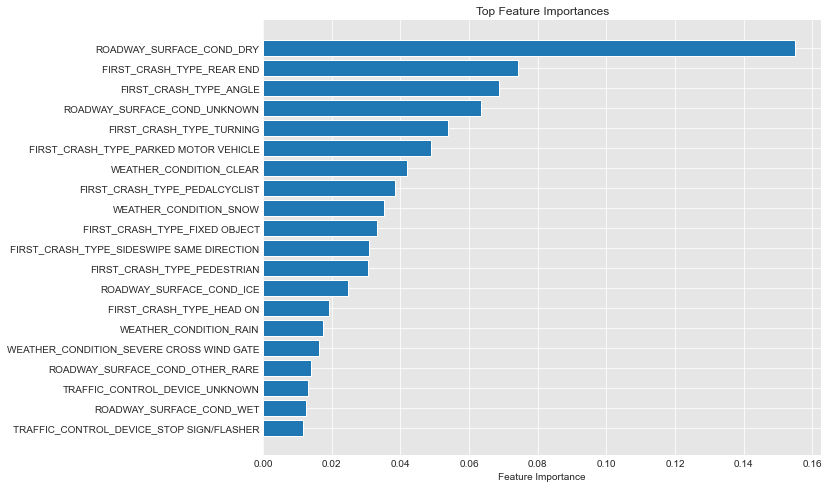

In [65]:
plot_feature_importances(xgb_model, preprocessor=preprocessor, categorical_cols=categorical_cols, numeric_cols=numeric_cols)